In [1]:
# -*- coding:utf8 -*-
import re
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from mydatools.plot import plot_grid_search_result

% matplotlib inline

## 获取数据

In [2]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')
full_df = pd.concat([train_df, test_df], keys=['train', 'test'])
del(train_df)
del(test_df)
full_df.head()

0_13_all  0_13_female  0_13_male  0_17_all  0_17_female  0_17_male  \
train 0     18654         8945       9709     23603        11317      12286   
      1     13729         6800       6929     17700         8702       8998   
      2     11252         5336       5916     14884         7063       7821   
      3     24934        12152      12782     32063        15550      16513   
      4     11631         5408       6223     15237         7124       8113   

         0_6_all  0_6_female  0_6_male  16_29_all         ...          \
train 0     9576        4677      4899      17508         ...           
      1     6880        3414      3466      15164         ...           
      2     5879        2784      3095      19401         ...           
      3    13087        6442      6645       3292         ...           
      4     5706        2724      2982       5164         ...           

         water_km  water_treatment_km  work_all  work_female  work_male  \
train 0  0.992631           23.683460     98207        45930      52277   
      1  0.698081            1.317476     70194        34572      35622   
      2  0.468265            4.912660     63388        31575      31813   
      3  1.200336           15.623710    120381        60341      60040   
      4  0.820294           10.683540     68043        33807      34236   

         workplaces_km  young_all  young_female  young_male  \
train 0       0.884350      21154         10147       11007   
      1       0.686252      15727          7802        7925   
      2       1.510089      13028          6193        6835   
      3       0.622272      28563         13883       14680   
      4       0.892668      13368          6209        7159   

         zd_vokzaly_avto_km  
train 0           14.231961  
      1            9.242586  
      2            9.540544  
      3           17.478380  
      4            1.595898  

[5 rows x 292 columns]

* 对price_doc进行log1p处理

由于有了这个操作，score就是RMSE（而不是RMSLE）

In [3]:
full_df['price_doc'] = np.log1p(full_df['price_doc'])

* macroeconomy

In [4]:
macro_df = pd.read_csv('./input/macro.csv')
macro_df.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


In [5]:
# feats = macro_df.columns[macro_df.dtypes != 'object'].tolist()[40:60]
# num_feat = len(feats)
# num_row = int(np.ceil(num_feat / 3))
# fig, ax = plt.subplots(num_row, 3, figsize=(15, 4*num_row))
# for i in range(num_feat):
#     feat = feats[i]
#     cur_ax = ax[i//3][i%3] if num_row > 1 else ax[i]
#     cur_ax.plot(pd.to_datetime(macro_df['timestamp']), macro_df[feat].fillna(0))
# #     cur_ax.plot(pd.to_datetime(macro_df['timestamp']), macro_df[feat].fillna(macro_df[feat].mean()))
#     cur_ax.plot(pd.to_datetime(macro_df['timestamp']), macro_df[feat].fillna(method='ffill').fillna(method='bfill'))
#     cur_ax.set_title(feat)

In [6]:
# 缺失值
numerical_columns = macro_df.columns[macro_df.dtypes != 'object']
macro_df[numerical_columns] = macro_df[numerical_columns].fillna(method='ffill').fillna(method='bfill')

In [7]:
full_df = full_df.join(macro_df.set_index('timestamp'), on='timestamp')

## 特征处理

* 简单处理

把数值型特征加进去

In [8]:
feature_list = []
def add_feature(feats):
    global feature_list
    if type(feats) != list:
        feats = [feats]
    feature_list += [f for f in feats if f not in feature_list]
def remove_feature(feats):
    global feature_list
    if type(feats) != list:
        feats = [feats]
    feature_list = [f for f in feature_list if f not in feats]

In [9]:
numeric_feat = full_df.dtypes[full_df.dtypes != 'object'].index.tolist()
add_feature(numeric_feat)

In [10]:
remove_feature(['id', 'price_doc'])

* 处理偏倚数据

In [11]:
skew_value = full_df[feature_list].apply(lambda x: skew(x)) # compute skewness
min_value = full_df[feature_list].min()
skewed_feats = skew_value[(skew_value > 0.75) & (min_value >= 0)].index
full_df[skewed_feats] = np.log1p(full_df[skewed_feats])

* 加入日期相关特征

In [12]:
dt_df = pd.to_datetime(full_df['timestamp'])
full_df['timestamp_year'] = dt_df.apply(lambda x: x.year)
full_df['timestamp_month'] = dt_df.apply(lambda x: x.month)
full_df['timestamp_day'] = dt_df.apply(lambda x: x.day)
full_df['timestamp_weekday'] = dt_df.apply(lambda x: x.weekday())
add_feature(['timestamp_year', 'timestamp_month', 'timestamp_day', 'timestamp_weekday'])

* 字符串类型特征处理

In [13]:
# yes/no
yes_no_features = ['big_market_raion', 'big_road1_1line', 'culture_objects_top_25',
        'detention_facility_raion', 'incineration_raion',
        'nuclear_reactor_raion', 'oil_chemistry_raion', 'radiation_raion',
        'railroad_1line', 'railroad_terminal_raion',
        'thermal_power_plant_raion', 'water_1line',
    ]
full_df[yes_no_features] = full_df[yes_no_features].apply(lambda x: x.map({'yes': 1, 'no': 0}))
add_feature(yes_no_features)

In [14]:
# ecology (excellent|good|satisfactory|poor|no data)
full_df['ecology'] = full_df['ecology'].map({'excellent': 4, 'good': 3, 'satisfactory': 2, 'poor': 1, 'no data': np.nan})
add_feature('ecology')

In [15]:
# dummy
# product_type (Investment|OwnerOccupier|nan)
dummy_features = ['product_type']
dummy_df = pd.get_dummies(full_df[dummy_features])
full_df[dummy_df.columns] = dummy_df
add_feature(dummy_df.columns.tolist())

In [16]:
# to numeric
# child_on_acc_pre_school (#!|7,311|3,013|16,765|nan)
# modern_education_share (nan|90,92|93,08|95,4918)
# old_education_build_share (nan|23,14|25,47|8,2517)
tonum_feats = ['child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share']
# 先将,转化成. 然后再进行to_numeric
full_df[tonum_feats] = full_df[tonum_feats].apply(lambda x: x.str.replace(',', '.'))
full_df[tonum_feats] = full_df[tonum_feats].apply(lambda x: pd.to_numeric(x, errors='coerce'))
add_feature(tonum_feats)

## 空值处理

In [17]:
full_df[feature_list] = preprocessing.Imputer().fit_transform(full_df[feature_list])
# full_df[feature_list] = full_df[feature_list].fillna(0)

## 预处理

In [18]:
X = full_df.loc['train'][feature_list]
y = full_df.loc['train']['price_doc']

X_pred = full_df.loc['test'][feature_list]

# 标准化
# scaler = preprocessing.StandardScaler()
# X = scaler.fit_transform(X)
# X_pred = scaler.transform(X_pred)

X_train = X
y_train = y

## Score

In [19]:
score_name = 'RMSE'
score_func = lambda y, y_pred, **kwargs: metrics.mean_squared_error(y, y_pred, **kwargs) ** 0.5
scorer = metrics.make_scorer(score_func, greater_is_better=False)

## Lasso

In [20]:
# from sklearn.linear_model import Lasso, LassoCV

In [21]:
# # 对Lasso做网格化搜索
# search_paras = {'alpha': np.logspace(-3,0,4)}
# gs_lasso = GridSearchCV(Lasso(), search_paras, scoring=scorer).fit(X_train, y_train)
# plot_grid_search_result(gs_lasso)

In [22]:
# # lasso = gs_lasso.best_estimator_
# lasso = Lasso(**gs_lasso.best_params_).fit(X_train, y_train)

In [23]:
# coef = lasso.coef_
# coef_df = pd.Series(coef, index=feature_list)
# coef_df = coef_df.sort_values(ascending=False)
# imp_coef_df = pd.concat([coef_df.head(10), coef_df.tail(5)])
# imp_coef_df.plot(kind='barh')

## XGBoost

In [24]:
import xgboost as xgb

In [25]:
xg_train = xgb.DMatrix(X_train, y_train, feature_names=feature_list)
xg_pred = xgb.DMatrix(X_pred, feature_names=feature_list)

In [26]:
bst_paras = {
    'objective': 'reg:linear',
    'booster': 'gbtree',
    'eval_metric': 'rmse',
    'eta': 0.02,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
    'max_depth': 5,
    'alpha': 0.1,
    'lambda': 0,
}
num_boost_round = 1000

In [27]:
# xgb_cv_res = xgb.cv(bst_paras, xg_train, num_boost_round, nfold=5, early_stopping_rounds=20, verbose_eval=25)
# best_round = np.argmin(xgb_cv_res['test-rmse-mean'])
# print('best_model:', xgb_cv_res.iloc[best_round])
best_round = 600

In [28]:
watchlist = [(xg_train, 'train'), (xg_train, 'valid')]
bst = xgb.train(bst_paras, xg_train, best_round, watchlist, verbose_eval=25)
# bst = xgb.train(bst_paras, xg_train, best_round)
print('train_loss:', score_func(y_train, bst.predict(xg_train)))

[0]	train-rmse:14.8195	valid-rmse:14.8195
[25]	train-rmse:8.95147	valid-rmse:8.95147
[50]	train-rmse:5.41521	valid-rmse:5.41521
[75]	train-rmse:3.2887	valid-rmse:3.2887
[100]	train-rmse:2.0178	valid-rmse:2.0178
[125]	train-rmse:1.26941	valid-rmse:1.26941
[150]	train-rmse:0.844298	valid-rmse:0.844298
[175]	train-rmse:0.618908	valid-rmse:0.618908
[200]	train-rmse:0.510829	valid-rmse:0.510829
[225]	train-rmse:0.463005	valid-rmse:0.463005
[250]	train-rmse:0.442301	valid-rmse:0.442301
[275]	train-rmse:0.432494	valid-rmse:0.432494
[300]	train-rmse:0.427202	valid-rmse:0.427202
[325]	train-rmse:0.423333	valid-rmse:0.423333
[350]	train-rmse:0.420587	valid-rmse:0.420587
[375]	train-rmse:0.417872	valid-rmse:0.417872
[400]	train-rmse:0.415614	valid-rmse:0.415614
[425]	train-rmse:0.413588	valid-rmse:0.413588
[450]	train-rmse:0.411651	valid-rmse:0.411651
[475]	train-rmse:0.409865	valid-rmse:0.409865
[500]	train-rmse:0.408039	valid-rmse:0.408039
[525]	train-rmse:0.406072	valid-rmse:0.406072
[550]	tra

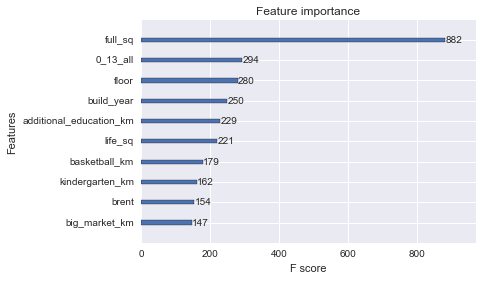

In [29]:
xgb.plot_importance(bst, max_num_features=10)

## 预测

In [30]:
# 使用的模型
# res_model = lasso
res_model = bst

# 预测
if type(res_model) == xgb.core.Booster:
    y_pred = res_model.predict(xg_pred)
else:
    y_pred = res_model.predict(X_pred)
y_pred = np.expm1(y_pred)

# 导出数据
res_df = pd.DataFrame({'id': full_df.loc['test']['id'], 'price_doc': y_pred})
res_df.to_csv('./output/result.csv', index=False)